In [128]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

from qiskit.circuit.library import efficient_su2
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_aer import AerSimulator

## Ideal Expectation Value

In [129]:
simulator = AerSimulator()

### 1.   Define an Observable

In [130]:
n = 6
observable_terms = [
            "I"*(i-1) + "Z" + "I"*(n - i)
            for i in range(1, n+1)
        ]
observable = SparsePauliOp(observable_terms, coeffs=[1/(n)] * (n))
print(observable)

SparsePauliOp(['ZIIIII', 'IZIIII', 'IIZIII', 'IIIZII', 'IIIIZI', 'IIIIIZ'],
              coeffs=[0.16666667+0.j, 0.16666667+0.j, 0.16666667+0.j, 0.16666667+0.j,
 0.16666667+0.j, 0.16666667+0.j])


In [131]:
obs_matrix = observable.to_matrix(sparse=True)

### 2. Find the ideal expectation value using scipy.linalg

In [132]:
from scipy.sparse.linalg import eigsh
eigenval, _ = eigsh(obs_matrix)
eigenval

array([-1.        , -0.66666667,  1.        ,  0.66666667, -0.66666667,
        0.66666667])

In [133]:
min_ideal_eigenvalue = float(min(eigenval))
print(min_ideal_eigenvalue)

-0.9999999999999998


## Ideal VQE

### 1. Define the Ansatz

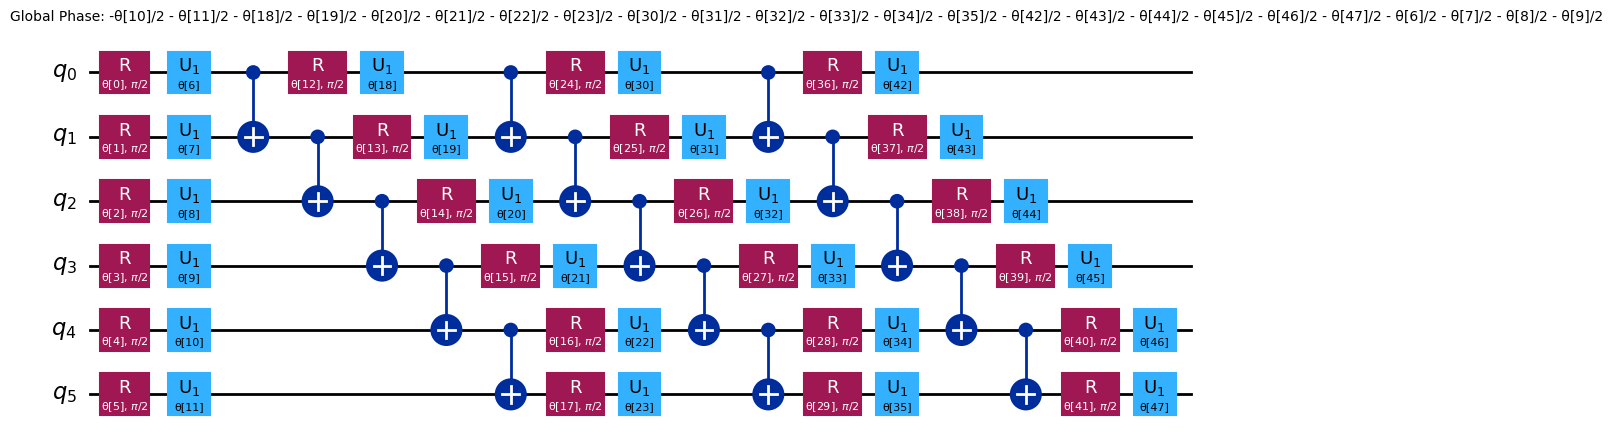

In [134]:
ansatz = efficient_su2(n, entanglement='linear', reps=3)
ansatz.decompose().draw("mpl", fold=-1)

### 2. Initial Parameters

In [135]:
np.random.seed(42)
x0 = 2 * np.pi * np.random.random(ansatz.num_parameters)

### 3. Find Optimal parameters for the VQE

In [136]:
def cost_function(params, ansatz, hamiltonian, estimator):
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]
    return energy

In [137]:
with Session(backend=AerSimulator()) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 10000

    res = minimize(
        cost_function,
        x0,
        args=(ansatz.copy(), observable, estimator),
        method="cobyla",
        options={'maxiter':4000}
    )

In [138]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.9717666666666666
       x: [ 2.841e+00  4.664e+00 ...  3.335e+00  2.888e+00]
    nfev: 642
   maxcv: 0.0

## Uncut VQE 

### 1. Transpile the Ansatz

In [139]:
from qiskit_ibm_runtime.fake_provider import FakeTorino
backend = FakeTorino()

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)

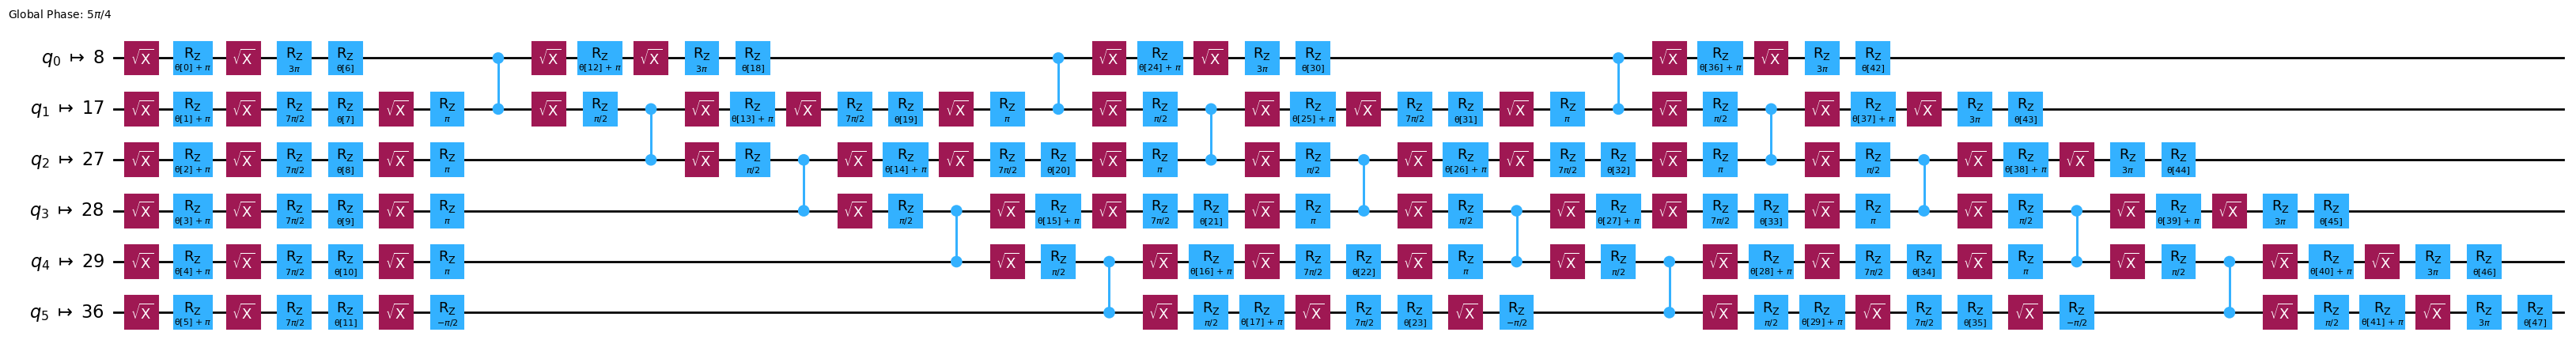

In [140]:
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp", fold=-1)

In [141]:
hamiltonian_isa = observable.apply_layout(layout=ansatz_isa.layout)

### 2. Assign Parameters to the transpiled Ansatz

In [142]:
ansatz_isa.assign_parameters(res.x, inplace=True)

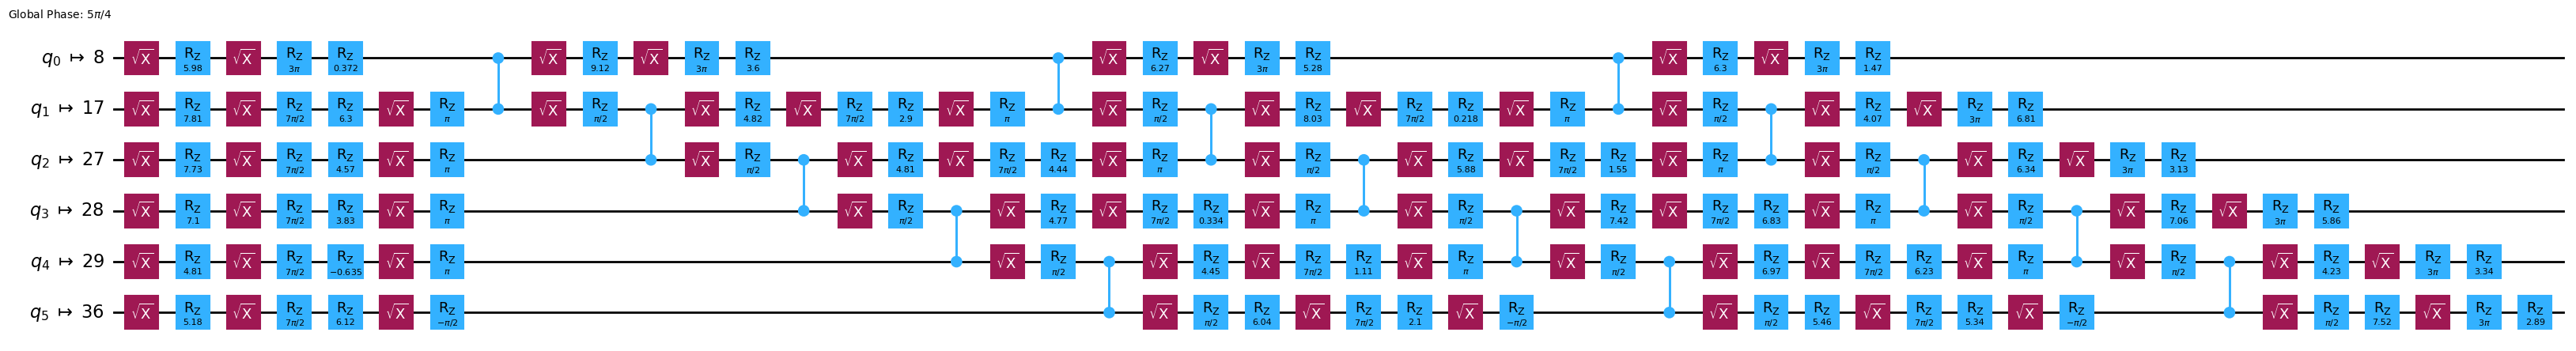

In [143]:
ansatz_isa.draw("mpl", fold=-1)

In [144]:
estimator = Estimator(mode=backend)

### 3. Create pub with 5 repetitions

In [ ]:
pub0=(ansatz_isa,hamiltonian_isa)


## Cut VQE

### 1. Assign the Parameters before Synthesis

In [145]:
to_be_synth_ansatz = ansatz.assign_parameters(res.x)

### 2. Synthesize the Ansatz 

In [146]:
pm_basis = generate_preset_pass_manager(optimization_level=3, basis_gates=backend.configuration().basis_gates, seed_transpiler=1)
synth_ansatz = pm_basis.run(to_be_synth_ansatz)

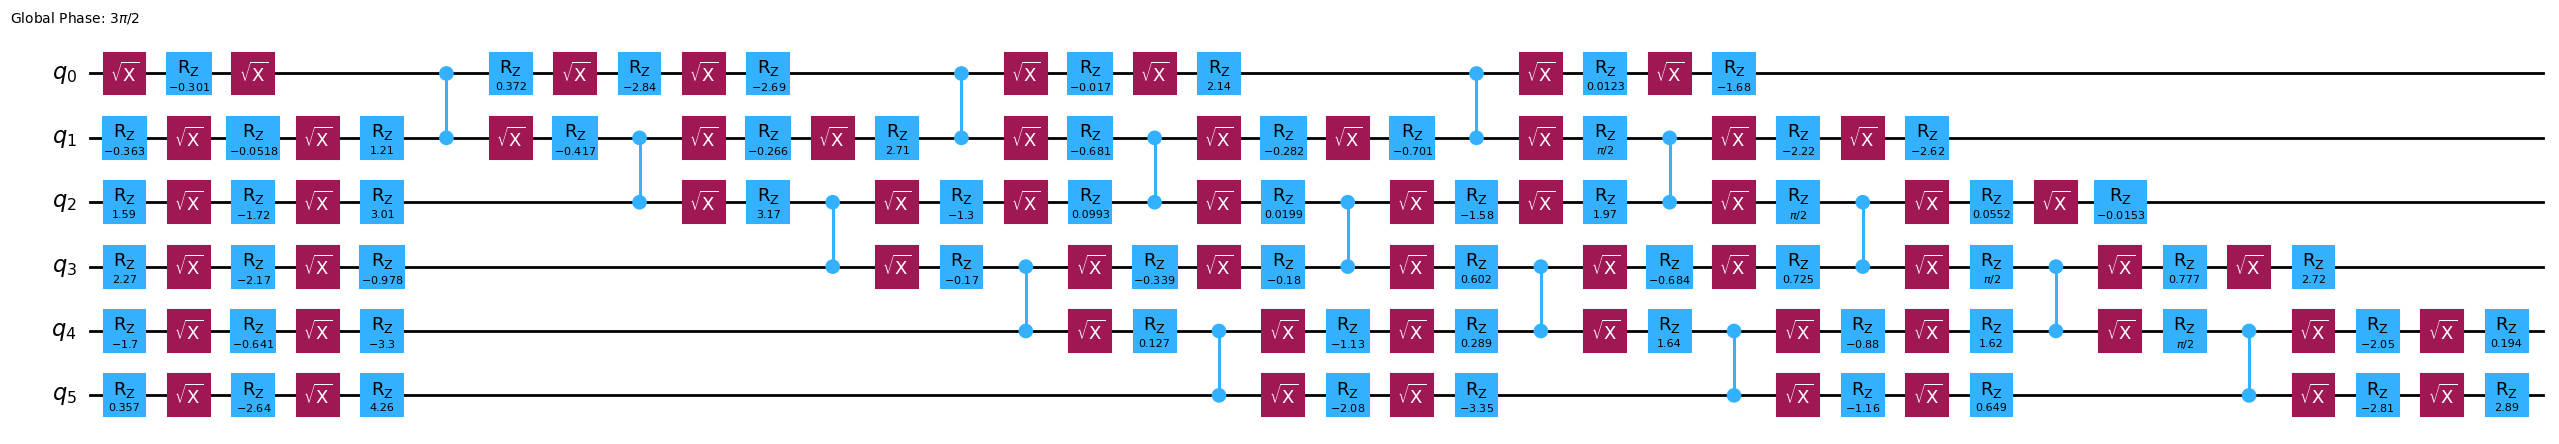

In [147]:
synth_ansatz.draw("mpl", fold=-1)

In [148]:
synth_ansatz.depth()

38

### 3. Cut the Synthesized Ansatz

Found solution using 3 cuts with a sampling overhead of 729.0.
Lowest cost solution found: True.
Gate Cut at circuit instruction index 66
Gate Cut at circuit instruction index 97
Gate Cut at circuit instruction index 120


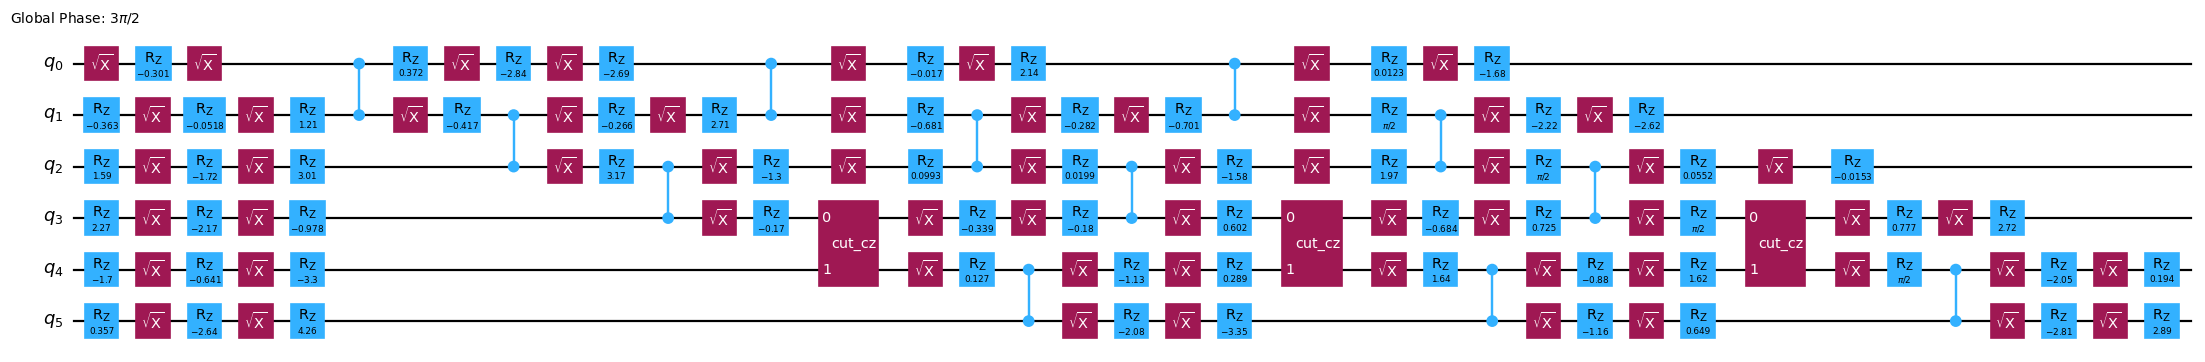

In [149]:
from qiskit_addon_cutting.automated_cut_finding import (
    find_cuts,
    OptimizationParameters,
    DeviceConstraints,
)

# Specify settings for the cut-finding optimizer
optimization_settings = OptimizationParameters(seed=111)


# Specify the size of the QPUs available
device_constraints = DeviceConstraints(qubits_per_subcircuit=(synth_ansatz.num_qubits/2)+1)

cut_circuit, metadata = find_cuts(synth_ansatz, optimization_settings, device_constraints)
#print(metadata)
print(
    f'Found solution using {len(metadata["cuts"])} cuts with a sampling '
    f'overhead of {metadata["sampling_overhead"]}.\n'
    f'Lowest cost solution found: {metadata["minimum_reached"]}.'
)
for cut in metadata["cuts"]:
    print(f"{cut[0]} at circuit instruction index {cut[1]}")
cut_circuit.draw("mpl", scale=0.8, fold=-1)

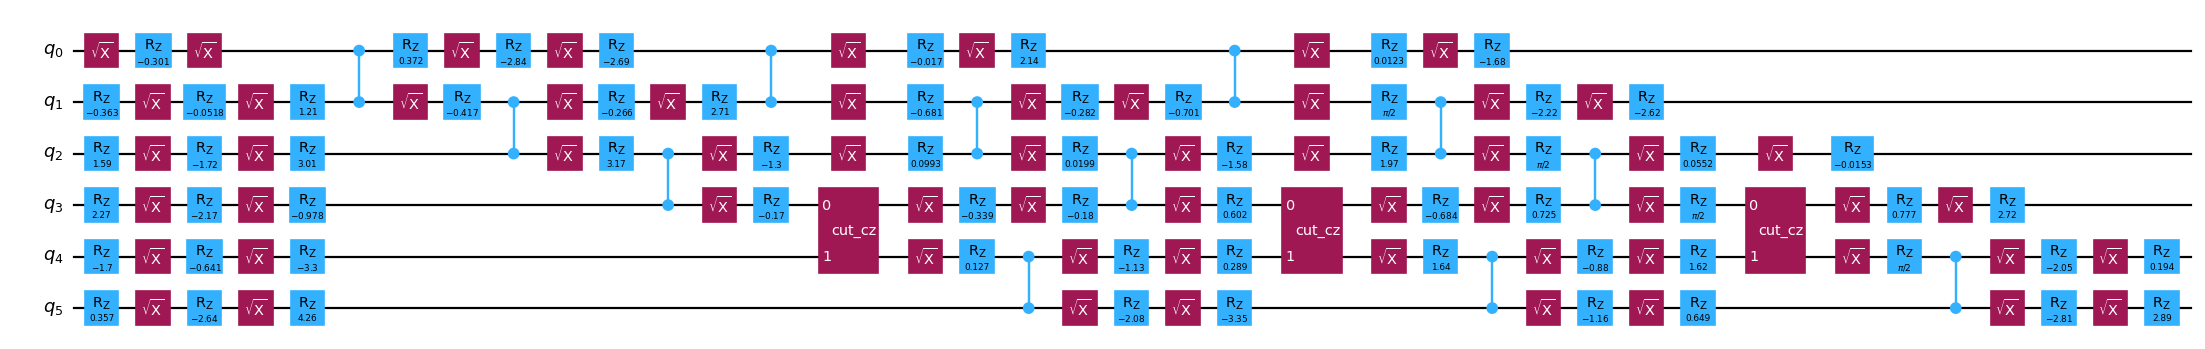

In [150]:
from qiskit_addon_cutting import cut_wires, expand_observables

qc_w_ancilla = cut_wires(cut_circuit)
observables_expanded = expand_observables(observable.paulis, synth_ansatz, qc_w_ancilla)
qc_w_ancilla.draw("mpl", scale=0.8, fold=-1)

In [151]:
from qiskit_addon_cutting import partition_problem

partitioned_problem = partition_problem(
    circuit=qc_w_ancilla, observables=observables_expanded
)
subcircuits = partitioned_problem.subcircuits
subobservables = partitioned_problem.subobservables
print(
    f"Sampling overhead: {np.prod([basis.overhead for basis in partitioned_problem.bases])}"
)

#subcircuits[1].draw("mpl")

Sampling overhead: 729.0


In [152]:
from qiskit_addon_cutting import generate_cutting_experiments

subexperiments, coefficients = generate_cutting_experiments(
    circuits=subcircuits, observables=subobservables, num_samples=np.inf
)
total_subexperiments = sum(len(subexperiments[i]) for i in list(subexperiments.keys()))
print(f"Total subexperiments are ",total_subexperiments)

Total subexperiments are  432


### 4. Transpile the Cut VQE

In [153]:
backend = FakeTorino()
# Transpile the subexperiments to ISA circuits
pass_manager =generate_preset_pass_manager(optimization_level=3, backend=backend, seed_transpiler=1)
isa_subexperiments = {
        label: pass_manager.run(partition_subexpts)
        for label, partition_subexpts in subexperiments.items()
        }

## OBP + Cut VQE

### 1. Slice the Synthesized Ansatz

In [154]:
from qiskit_addon_utils.slicing import slice_by_depth

# Slice the isa_circuit by depth
synthesized_slices = slice_by_depth(synth_ansatz, max_slice_depth=1)
print(f"Slice_by_depth separated the circuit into {len(synthesized_slices)} slices.")

Slice_by_depth separated the circuit into 38 slices.


### 2. Define Operator Budget

In [155]:
from qiskit_addon_obp.utils.simplify import OperatorBudget
# Define an operator budget list
max_qwc_groups= 4
op_budget = OperatorBudget(max_qwc_groups=max_qwc_groups)

### 3. Backpropagate the Synthesized Ansatz 

Depth of the backpropagated circuit is:  30


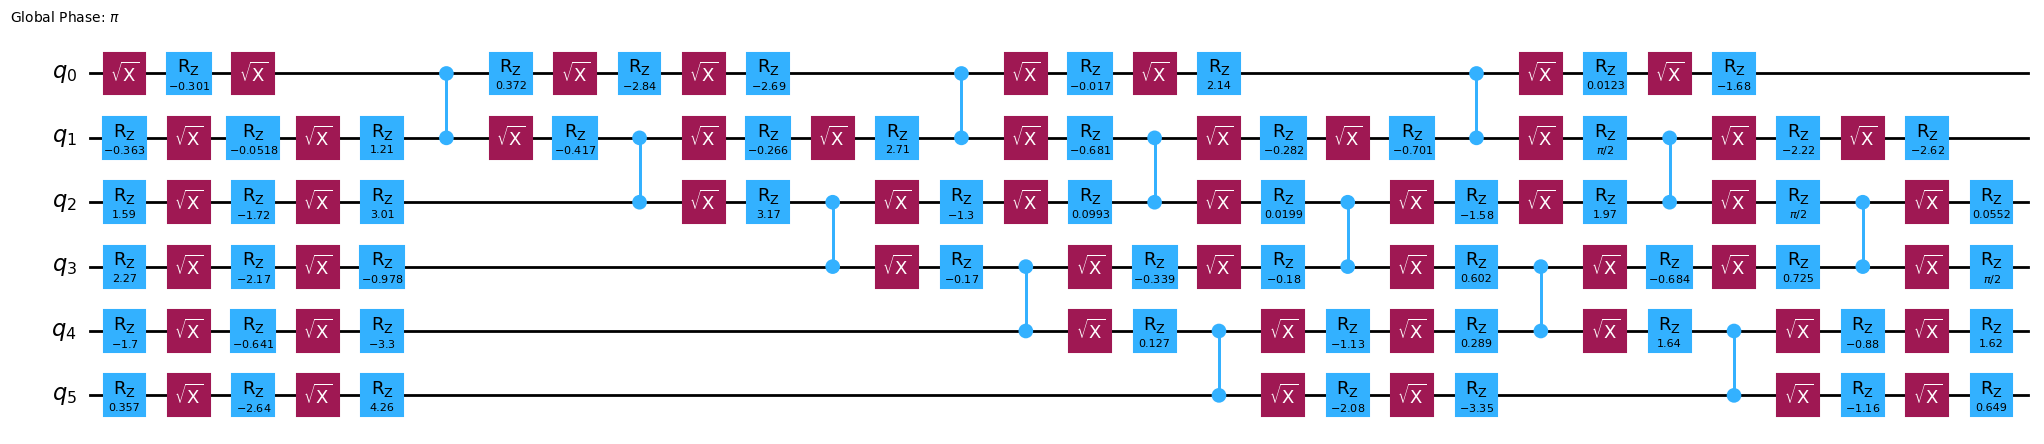

In [156]:
from qiskit_addon_obp import backpropagate
from qiskit_addon_utils.slicing import combine_slices
# Backpropagate without the truncation error budget

backpropagated_observable, remaining_slices, metadata = backpropagate(
    observable,
    synthesized_slices,
    operator_budget=op_budget,
    )
    # Recombine the slices remaining after backpropagation
bp_circuit = combine_slices(remaining_slices, include_barriers=False)
num_non_commuting_groups=backpropagated_observable.group_commuting()
if bp_circuit != None:
        print(f"Depth of the backpropagated circuit is: ", bp_circuit.depth())

bp_circuit.draw("mpl", fold=-1)


### 4. Find Cuts in the Backpropagated Circuit

Found solution using 2 cuts with a sampling overhead of 81.0.



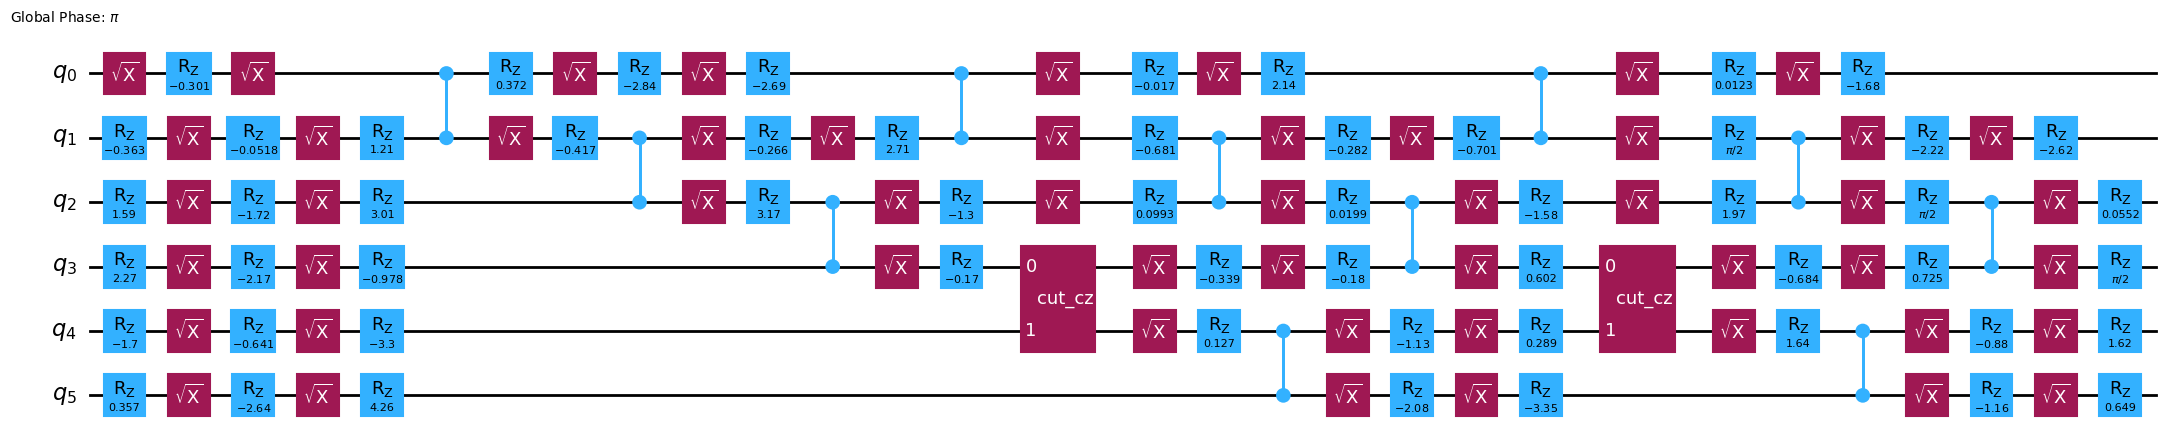

In [157]:
# Form the list of cut circuits
from qiskit_addon_cutting.automated_cut_finding import (
    find_cuts,
    OptimizationParameters,
    DeviceConstraints,
)

# Specify settings for the cut-finding optimizer
optimization_settings = OptimizationParameters(seed=111)
    # Specify the size of the QPUs available
device_constraints = DeviceConstraints(qubits_per_subcircuit=(bp_circuit.num_qubits/2)+1)

bp_cut_circuit, bp_cut_metadata = find_cuts(bp_circuit, optimization_settings, device_constraints)
    #print(metadata)
print(
        f'Found solution using {len(bp_cut_metadata["cuts"])} cuts with a sampling '
        f'overhead of {bp_cut_metadata["sampling_overhead"]}.\n'
        #f'Lowest cost solution found: {bp_metadata["minimum_reached"]}.'
    )
bp_cut_circuit.draw("mpl", fold=-1)

In [158]:
from qiskit_addon_cutting import cut_wires, expand_observables

qc_w_ancilla_obp = cut_wires(bp_cut_circuit)
observables_expanded_obp = expand_observables(backpropagated_observable.paulis, bp_circuit, qc_w_ancilla_obp)
 

In [159]:
partitioned_problem_obp = partition_problem(
        circuit=qc_w_ancilla_obp, observables=observables_expanded_obp
    )
subcircuits_obp = partitioned_problem_obp.subcircuits
subobservables_obp = partitioned_problem_obp.subobservables
print(
        f"Sampling overhead: {np.prod([basis.overhead for basis in partitioned_problem_obp.bases])}"
    )

Sampling overhead: 81.0


### 5. Find the total number of Subexperiments

In [160]:
from qiskit_addon_cutting import generate_cutting_experiments
subexperiments_obp, coefficients_obp = generate_cutting_experiments(
        circuits=subcircuits_obp, observables=subobservables_obp, num_samples=np.inf
    )
total_subexperiments_obp= sum(len(subexperiments_obp[i]) for i in list(subexperiments_obp.keys()))
    

print(total_subexperiments_obp)

144


### 6. Transpile the OBP + Cut VQE

In [161]:
# Transpile the subexperiments to ISA circuits
pass_manager =generate_preset_pass_manager(optimization_level=3, backend=backend, seed_transpiler=1)
isa_subexperiments_obp_cut = {
        label: pass_manager.run(partition_subexpts)
        for label, partition_subexpts in subexperiments_obp.items()
        }


## OBP + Cut + Truncation

In [162]:
from qiskit_addon_utils.slicing import slice_by_depth

# Slice the isa_circuit by depth
synthesized_slices = slice_by_depth(synth_ansatz, max_slice_depth=1)
print(f"Slice_by_depth separated the circuit into {len(synthesized_slices)} slices.")

Slice_by_depth separated the circuit into 38 slices.


In [163]:
from qiskit_addon_obp.utils.simplify import OperatorBudget

# Define an operator budget list
max_qwc_groups= 5
op_budget = OperatorBudget(max_qwc_groups=max_qwc_groups)

In [164]:
from qiskit_addon_obp.utils.truncating import setup_budget
truncation_error_budget = setup_budget(max_error_total=0.14350000000000002)

In [165]:
from qiskit_addon_obp import backpropagate
from qiskit_addon_utils.slicing import combine_slices
# Backpropagate without the truncation error budget

backpropagated_observable_trunc, remaining_slices_trunc, metadata_trunc = backpropagate(
    observable,
    synthesized_slices,
    operator_budget=op_budget,
    truncation_error_budget=truncation_error_budget
    )

# Recombine the slices remaining after backpropagation
bp_circuit_trunc = combine_slices(remaining_slices_trunc, include_barriers=False)
num_non_commuting_groups=backpropagated_observable_trunc.group_commuting()
if bp_circuit_trunc != None:
        print(f"Depth of the backpropagated circuit is: ", bp_circuit_trunc.depth())




Depth of the backpropagated circuit is:  25


In [166]:
# Form the list of cut circuits
from qiskit_addon_cutting.automated_cut_finding import (
    find_cuts,
    OptimizationParameters,
    DeviceConstraints,
)

# Specify settings for the cut-finding optimizer
optimization_settings = OptimizationParameters(seed=111)
# Specify the size of the QPUs available
device_constraints = DeviceConstraints(qubits_per_subcircuit=(bp_circuit_trunc.num_qubits/2)+1)

bp_cut_circuit_trunc, bp_cut_metadata_trunc = find_cuts(bp_circuit_trunc, optimization_settings, device_constraints)
#print(metadata)
print(
        f'Found solution using {len(bp_cut_metadata_trunc["cuts"])} cuts with a sampling '
        f'overhead of {bp_cut_metadata_trunc["sampling_overhead"]}.\n'
        #f'Lowest cost solution found: {bp_metadata["minimum_reached"]}.'
    )


Found solution using 2 cuts with a sampling overhead of 81.0.



In [167]:
from qiskit_addon_cutting import cut_wires, expand_observables

qc_w_ancilla_obp_trunc = cut_wires(bp_cut_circuit_trunc)
observables_expanded_obp_trunc = expand_observables(backpropagated_observable_trunc.paulis, bp_circuit_trunc, qc_w_ancilla_obp_trunc)
 

In [168]:
partitioned_problem_obp_trunc = partition_problem(
        circuit=qc_w_ancilla_obp_trunc, observables=observables_expanded_obp_trunc
    )
subcircuits_obp_trunc = partitioned_problem_obp_trunc.subcircuits
subobservables_obp_trunc = partitioned_problem_obp_trunc.subobservables
print(
        f"Sampling overhead: {np.prod([basis.overhead for basis in partitioned_problem_obp_trunc.bases])}"
    )

Sampling overhead: 81.0


In [169]:
from qiskit_addon_cutting import generate_cutting_experiments

subexperiments_obp_trunc, coefficients_obp_trunc = generate_cutting_experiments(
        circuits=subcircuits_obp_trunc, observables=subobservables_obp_trunc, num_samples=np.inf
    )
total_subexperiments_obp_trunc= sum(len(subexperiments_obp_trunc[i]) for i in list(subexperiments_obp_trunc.keys()))
    
print(total_subexperiments_obp_trunc)

252


In [ ]:
# Transpile the subexperiments to ISA circuits 
pass_manager =generate_preset_pass_manager(optimization_level=3, backend=backend, seed_transpiler=1)
isa_subexperiments_obp_cut_trunc = {
        label: pass_manager.run(partition_subexpts)
        for label, partition_subexpts in subexperiments_obp_trunc.items()
        }

In [171]:
from qiskit_ibm_runtime import SamplerV2, Batch
num_trials = 5

jobs_cut_trunc = {}

with Batch(backend=backend) as batch:
    sampler = SamplerV2(mode=batch)
    for idx in range(num_trials):
        job_trial = {
            label: sampler.run(subsystem_subexpts, shots=10000)
            for label, subsystem_subexpts in isa_subexperiments_obp_cut_trunc.items()
        }
        jobs_cut_trunc[idx] = job_trial
results_cut_trunc = {}

for idx in range(num_trials):
    result_trial = {label: job.result() for label, job in jobs_cut_trunc[idx].items()}
    results_cut_trunc[idx] = result_trial
from qiskit_addon_cutting import reconstruct_expectation_values

reconstructed_expvals_trunc = []

for idx in range(num_trials):
    reconstructed_expval_terms_trunc = reconstruct_expectation_values(
        results_cut_trunc[idx],
        coefficients_obp_trunc,
        subobservables_obp_trunc,
    )
    reconstructed_expval_trunc = np.dot(reconstructed_expval_terms_trunc, backpropagated_observable_trunc.coeffs).real
    reconstructed_expvals_trunc.append(reconstructed_expval_trunc)
mean_reconstructed_expval_trunc = np.mean(reconstructed_expvals_trunc)
std_reconstructed_expval_trunc = np.std(reconstructed_expvals_trunc)

print(f'Mean expectation value with cutting is {mean_reconstructed_expval_trunc} with a standard deviation of {std_reconstructed_expval_trunc}')

Mean expectation value with cutting is -0.8616006469896667 with a standard deviation of 0.004980579894087478


## Rough

In [ ]:
# # Define an operator budget list
# import numpy as np
# operator_budget_list = []
# max_qwc_groups_list = np.arange(1,41)
# for max_qwc_groups in max_qwc_groups_list:
#     op_budget = OperatorBudget(max_qwc_groups=max_qwc_groups)
#     operator_budget_list.append(op_budget)
# print(operator_budget_list)
# # Slice the isa_circuit by depth
# synthesized_slices = slice_by_depth(synth_ansatz, max_slice_depth=1)
# print(f"Slice_by_depth separated the circuit into {len(synthesized_slices)} slices.")

[OperatorBudget(max_paulis=None, max_qwc_groups=np.int64(1), simplify=True, atol=None, rtol=None), OperatorBudget(max_paulis=None, max_qwc_groups=np.int64(2), simplify=True, atol=None, rtol=None), OperatorBudget(max_paulis=None, max_qwc_groups=np.int64(3), simplify=True, atol=None, rtol=None), OperatorBudget(max_paulis=None, max_qwc_groups=np.int64(4), simplify=True, atol=None, rtol=None), OperatorBudget(max_paulis=None, max_qwc_groups=np.int64(5), simplify=True, atol=None, rtol=None), OperatorBudget(max_paulis=None, max_qwc_groups=np.int64(6), simplify=True, atol=None, rtol=None), OperatorBudget(max_paulis=None, max_qwc_groups=np.int64(7), simplify=True, atol=None, rtol=None), OperatorBudget(max_paulis=None, max_qwc_groups=np.int64(8), simplify=True, atol=None, rtol=None), OperatorBudget(max_paulis=None, max_qwc_groups=np.int64(9), simplify=True, atol=None, rtol=None), OperatorBudget(max_paulis=None, max_qwc_groups=np.int64(10), simplify=True, atol=None, rtol=None), OperatorBudget(max

In [87]:
# truncation_error_budget = setup_budget(max_error_total=0.14350000000000002)

In [ ]:
# # Backpropagate without the truncation error budget
# bp_circuit_list =[]
# commuting_groups_list=[] # Stores the list of the non-commuting groups after backpropagation
# backpropagated_observable_list =[]

# for op_budget in operator_budget_list:
#     backpropagated_observable, remaining_slices, metadata = backpropagate(
#     observable,
#     synthesized_slices,
#     operator_budget=op_budget
#     )
#     # Recombine the slices remaining after backpropagation
#     bp_circuit = combine_slices(remaining_slices, include_barriers=False)
#     num_non_commuting_groups=backpropagated_observable.group_commuting()
#     if bp_circuit != None:
#         print(f"Depth of the backpropagated circuit is: ", bp_circuit.depth())
#     #else:
#     #    bp_circuit =QuantumCircuit(circuit.num_qubits)
#     bp_circuit_list.append(bp_circuit)
#     commuting_groups_list.append(len(num_non_commuting_groups))
#     backpropagated_observable_list.append(backpropagated_observable)



Depth of the backpropagated circuit is:  36
Depth of the backpropagated circuit is:  30
Depth of the backpropagated circuit is:  30
Depth of the backpropagated circuit is:  30
Depth of the backpropagated circuit is:  28
Depth of the backpropagated circuit is:  28
Depth of the backpropagated circuit is:  28
Depth of the backpropagated circuit is:  28
Depth of the backpropagated circuit is:  28
Depth of the backpropagated circuit is:  28
Depth of the backpropagated circuit is:  27
Depth of the backpropagated circuit is:  27
Depth of the backpropagated circuit is:  27
Depth of the backpropagated circuit is:  27
Depth of the backpropagated circuit is:  27
Depth of the backpropagated circuit is:  27
Depth of the backpropagated circuit is:  27
Depth of the backpropagated circuit is:  27
Depth of the backpropagated circuit is:  27
Depth of the backpropagated circuit is:  24
Depth of the backpropagated circuit is:  24
Depth of the backpropagated circuit is:  24
Depth of the backpropagated circ

In [ ]:
# # Form the list of cut circuits
# bp_cut_circuit_list =[]
# bp_num_cuts_list =[]
# bp_cut_sampling_overhead_list =[]
# from qiskit_addon_cutting.automated_cut_finding import (
#     find_cuts,
#     OptimizationParameters,
#     DeviceConstraints,
# )

# # Specify settings for the cut-finding optimizer
# optimization_settings = OptimizationParameters(seed=111)

# for bp_circuit in bp_circuit_list:
#     # Specify the size of the QPUs available
#     device_constraints = DeviceConstraints(qubits_per_subcircuit=(bp_circuit.num_qubits/2)+1)

#     bp_cut_circuit, bp_cut_metadata = find_cuts(bp_circuit, optimization_settings, device_constraints)
#     #print(metadata)
#     print(
#         f'Found solution using {len(bp_cut_metadata["cuts"])} cuts with a sampling '
#         f'overhead of {bp_cut_metadata["sampling_overhead"]}.\n'
#         #f'Lowest cost solution found: {bp_metadata["minimum_reached"]}.'
#     )
#     bp_cut_circuit_list.append(bp_cut_circuit)
#     bp_num_cuts_list.append(len(bp_cut_metadata["cuts"]))
#     bp_cut_sampling_overhead_list.append(bp_cut_metadata["sampling_overhead"])


# print(bp_cut_circuit_list)
# print(bp_num_cuts_list)
# print(bp_cut_sampling_overhead_list)

Found solution using 3 cuts with a sampling overhead of 729.0.

Found solution using 2 cuts with a sampling overhead of 81.0.

Found solution using 2 cuts with a sampling overhead of 81.0.

Found solution using 2 cuts with a sampling overhead of 81.0.

Found solution using 2 cuts with a sampling overhead of 81.0.

Found solution using 2 cuts with a sampling overhead of 81.0.

Found solution using 2 cuts with a sampling overhead of 81.0.

Found solution using 2 cuts with a sampling overhead of 81.0.

Found solution using 2 cuts with a sampling overhead of 81.0.

Found solution using 2 cuts with a sampling overhead of 81.0.

Found solution using 2 cuts with a sampling overhead of 81.0.

Found solution using 2 cuts with a sampling overhead of 81.0.

Found solution using 2 cuts with a sampling overhead of 81.0.

Found solution using 2 cuts with a sampling overhead of 81.0.

Found solution using 2 cuts with a sampling overhead of 81.0.

Found solution using 2 cuts with a sampling overhead o

In [ ]:
# from qiskit_addon_cutting import cut_wires, expand_observables
# qc_w_ancilla_list=[]
# observables_expanded_list=[]
# for cut_ckt, bp_obs, bp_ckt in zip(bp_cut_circuit_list, backpropagated_observable_list, bp_circuit_list):
#     qc_w_ancilla = cut_wires(cut_ckt)
#     observables_expanded = expand_observables(bp_obs.paulis, bp_ckt, qc_w_ancilla)
#     qc_w_ancilla_list.append(qc_w_ancilla)
#     observables_expanded_list.append(observables_expanded)
    
    
#     #qc_w_ancilla.draw("mpl", scale=0.8, fold=-1)
# print(qc_w_ancilla_list)
# print(observables_expanded_list)

[<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x4897e0380>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x4167b32c0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x489942090>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x4111c68a0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x4111c79b0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x3b22186e0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x3b2219700>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x3b221a2d0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x3b221ae70>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x3b221b9b0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x32c0805f0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x32c0811f0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x32c081d60>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x32c082900>, <qiskit.circuit.qua

In [ ]:
# from qiskit_addon_cutting import partition_problem

# subcircuits_list =[]
# subobservables_list =[]
# for qc_w_anc, obs_expan in zip(qc_w_ancilla_list, observables_expanded_list):

#     partitioned_problem = partition_problem(
#         circuit=qc_w_anc, observables=obs_expan
#     )
#     subcircuits = partitioned_problem.subcircuits
#     subobservables = partitioned_problem.subobservables
#     print(
#         f"Sampling overhead: {np.prod([basis.overhead for basis in partitioned_problem.bases])}"
#     )
#     subcircuits_list.append(subcircuits)
#     subobservables_list.append(subobservables)
#     #subcircuits[1].draw("mpl")
# print(subcircuits_list)
# print(subobservables_list)

Sampling overhead: 729.0
Sampling overhead: 81.0
Sampling overhead: 81.0
Sampling overhead: 81.0
Sampling overhead: 81.0
Sampling overhead: 81.0
Sampling overhead: 81.0
Sampling overhead: 81.0
Sampling overhead: 81.0
Sampling overhead: 81.0
Sampling overhead: 81.0
Sampling overhead: 81.0
Sampling overhead: 81.0
Sampling overhead: 81.0
Sampling overhead: 81.0
Sampling overhead: 81.0
Sampling overhead: 81.0
Sampling overhead: 81.0
Sampling overhead: 81.0
Sampling overhead: 81.0
Sampling overhead: 81.0
Sampling overhead: 81.0
Sampling overhead: 81.0
Sampling overhead: 81.0
Sampling overhead: 81.0
Sampling overhead: 81.0
Sampling overhead: 81.0
Sampling overhead: 81.0
Sampling overhead: 81.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
[{0: <qiskit.circuit.quantumcircuit.QuantumCircuit

In [ ]:
# from qiskit_addon_cutting import generate_cutting_experiments

# subexperiments_list =[]

# for subckt, subobs in zip(subcircuits_list, subobservables_list):
#     subexperiments, coefficients = generate_cutting_experiments(
#         circuits=subckt, observables=subobs, num_samples=np.inf
#     )
#     #print(subexperiments)
#     #break
#     # print(
#     #     f"{len(subexperiments[0]) + len(subexperiments[1])} total subexperiments to run on backend."
#     # )
#     # for i in list(subexperiments.keys()):
#     #     subexperiments = len(subexperiments[i])
#     # subexperiments_list.append(subexperiments)
    
#     total_subexperiments = sum(len(subexperiments[i]) for i in list(subexperiments.keys()))
#     subexperiments_list.append(total_subexperiments)
    

# print(subexperiments_list)

[432, 144, 144, 144, 252, 252, 252, 252, 252, 252, 396, 396, 396, 396, 396, 396, 396, 396, 396, 432, 432, 432, 432, 432, 432, 432, 432, 540, 540, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 120]


## Hardware Execution

In [33]:
from qiskit_ibm_runtime import SamplerV2, Batch, EstimatorV2
num_trials = 5

jobs_cut ={}
jobs_obp_cut ={}

with Batch(backend=backend) as batch:
    # Uncut Executions
    estimator =EstimatorV2(mode=batch)
    job_uncut=estimator.run([pub0,pub0,pub0,pub0,pub0])

    # Cut Executions
    sampler = SamplerV2(mode=batch)
    for idx in range(num_trials):
        job_trial = {
            label: sampler.run(subsystem_subexpts, shots=10000)
            for label, subsystem_subexpts in isa_subexperiments.items()
        }
        jobs_cut[idx] = job_trial

    # Cut + OBP Executions
    for idx in range(num_trials):
        job_trial = {
            label: sampler.run(subsystem_subexpts, shots=10000)
            for label, subsystem_subexpts in isa_subexperiments_obp_cut.items()
        }
        jobs_obp_cut[idx] = job_trial
    

In [34]:
batch_id = batch.session_id
print(batch_id)

None


## Post-Processing

### 1. UnCut VQE

In [35]:
result_uncut = job_uncut.result()
exp_val_uncut = [result_uncut[i].data.evs for i in range(num_trials)]
print(exp_val_uncut)

[array(-0.85904948), array(-0.87776693), array(-0.86499023), array(-0.86702474), array(-0.85668945)]


### 2. Cut VQE

In [36]:
results_cut = {}
for idx in range(num_trials):
    result_trial = {label: job.result() for label, job in jobs_cut[idx].items()}
    results_cut[idx] = result_trial
from qiskit_addon_cutting import reconstruct_expectation_values

reconstructed_expvals = []

for idx in range(num_trials):
    reconstructed_expval_terms = reconstruct_expectation_values(
        results_cut[idx],
        coefficients,
        subobservables,
    )
    reconstructed_expval = np.dot(reconstructed_expval_terms, observable.coeffs).real
    reconstructed_expvals.append(reconstructed_expval)
mean_reconstructed_expval = np.mean(reconstructed_expvals)
std_reconstructed_expval = np.std(reconstructed_expvals)

print(f'Mean expectation value with cutting is {mean_reconstructed_expval} with a standard deviation of {std_reconstructed_expval}')

Mean expectation value with cutting is -0.8995411289998391 with a standard deviation of 0.0049816015026245076


### 3. OBP + Cut VQE

In [38]:
results_obp_cut = {}
for idx in range(num_trials):
    result_trial = {label: job.result() for label, job in jobs_obp_cut[idx].items()}
    results_obp_cut[idx] = result_trial
from qiskit_addon_cutting import reconstruct_expectation_values

reconstructed_expvals_obp = []

for idx in range(num_trials):
    reconstructed_expval_terms_obp = reconstruct_expectation_values(
        results_obp_cut[idx],
        coefficients_obp,
        subobservables_obp,
    )
    reconstructed_expval_obp = np.dot(reconstructed_expval_terms_obp, backpropagated_observable.coeffs).real
    reconstructed_expvals_obp.append(reconstructed_expval_obp)
mean_reconstructed_expval_obp = np.mean(reconstructed_expvals_obp)
std_reconstructed_expval_obp = np.std(reconstructed_expvals_obp)

print(f'Mean expectation value with cutting is {mean_reconstructed_expval_obp} with a standard deviation of {std_reconstructed_expval_obp}')

Mean expectation value with cutting is -0.9056405856055131 with a standard deviation of 0.0014744530507883415
